## Data Exploration and Feature Selection

#### Importing Libraries

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import category_encoders as ce
from scipy.stats import variation
from sklearn.linear_model import LinearRegression

#### Importing dataset

In [89]:
df = pd.read_csv("data.csv")

#### Initial exploration

In [90]:
df.shape

(37994, 12)

In [91]:
df.head(1)

,year,month,duoarea,area-name,product,product-name,process,process-name,series,series-description,value,units
0,2014,1,SFL,FLORIDA,EPG0,Natural Gas,VCS,Commercial Consumption,N3020FL2,Natural Gas Deliveries to Commercial Consumers...,6605.0,MMCF


In [92]:
df.columns.to_list()

['year',
 'month',
 'duoarea',
 'area-name',
 'product',
 'product-name',
 'process',
 'process-name',
 'series',
 'series-description',
 'value',
 'units']

In [93]:
df['timestamp'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df = df.drop(columns=['year', 'month'])

df = df.set_index('timestamp').sort_index()

print(df.head())

           duoarea area-name product product-name process  \
timestamp                                                   
2014-01-01     SFL   FLORIDA    EPG0  Natural Gas     VCS   
2014-01-01     SNH    USA-NH    EPG0  Natural Gas     VCS   
2014-01-01     SOR    USA-OR    EPG0  Natural Gas     VCS   
2014-01-01     SDE    USA-DE    EPG0  Natural Gas     VCS   
2014-01-01     SAZ    USA-AZ    EPG0  Natural Gas     VCS   

                      process-name    series  \
timestamp                                      
2014-01-01  Commercial Consumption  N3020FL2   
2014-01-01  Commercial Consumption  N3020NH2   
2014-01-01  Commercial Consumption  N3020OR2   
2014-01-01  Commercial Consumption  N3020DE2   
2014-01-01  Commercial Consumption  N3020AZ2   

                                           series-description   value units  
timestamp                                                                    
2014-01-01  Natural Gas Deliveries to Commercial Consumers...  6605.0  MMCF  
2

In [94]:
df.dtypes

duoarea                object
area-name              object
product                object
product-name           object
process                object
process-name           object
series                 object
series-description     object
value                 float64
units                  object
dtype: object

##### Missing Value handling

In [95]:
df.isna().sum().sum()

np.int64(476)

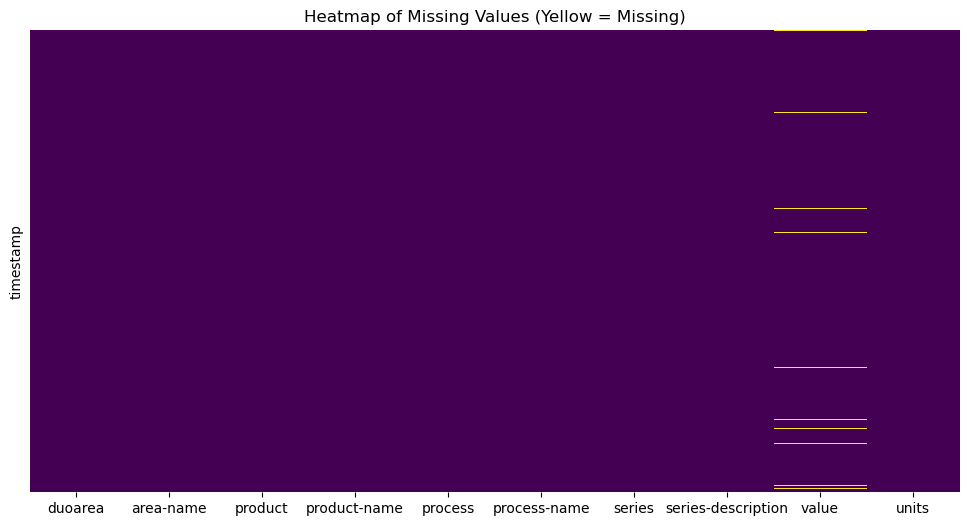

In [96]:
plt.figure(figsize=(12, 6))
sn.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')

plt.title('Heatmap of Missing Values (Yellow = Missing)')
plt.show()

In [97]:
print(f"Percentage of rows with null values {df.isna().sum().sum()*100/df.shape[0]}%")

Percentage of rows with null values 1.2528293941148603%


##### So, we can safely drop the rows without affecting the data distribution

In [98]:
df.dropna(axis=0, inplace=True)

In [99]:
df.shape

(37518, 10)

In [100]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical Columns ({len(num_cols)}):")
print(num_cols)
print("-" * 30)

print(f"Categorical Columns ({len(cat_cols)}):")
print(cat_cols)
print("-" * 30)

Numerical Columns (1):
['value']
------------------------------
Categorical Columns (9):
['duoarea', 'area-name', 'product', 'product-name', 'process', 'process-name', 'series', 'series-description', 'units']
------------------------------


In [101]:
print(df.select_dtypes(include=['object', 'category']).nunique())

duoarea                52
area-name              52
product                 1
product-name            1
process                 8
process-name            8
series                313
series-description    313
units                   1
dtype: int64


In [102]:
cols_to_drop = [
    'product', 'product-name', 'units',       # Constant values
    'area-name', 'process-name', 'series-description' # Redundant
]

In [103]:
dfcopy = df.copy()
df = df.drop(columns=cols_to_drop)

In [104]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [105]:
cat_cols

['duoarea', 'process', 'series']

In [106]:
encoder = ce.TargetEncoder(cols=['duoarea', 'series'])

C:\Users\sigma\AppData\Local\Temp\ipykernel_28052\3425175085.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=top_n.values, y=top_n.index, ax=axes[i], palette='viridis')
C:\Users\sigma\AppData\Local\Temp\ipykernel_28052\3425175085.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=top_n.values, y=top_n.index, ax=axes[i], palette='viridis')
C:\Users\sigma\AppData\Local\Temp\ipykernel_28052\3425175085.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x=top_n.values, y=top_n.index, ax=axes[i], palette='viridis')


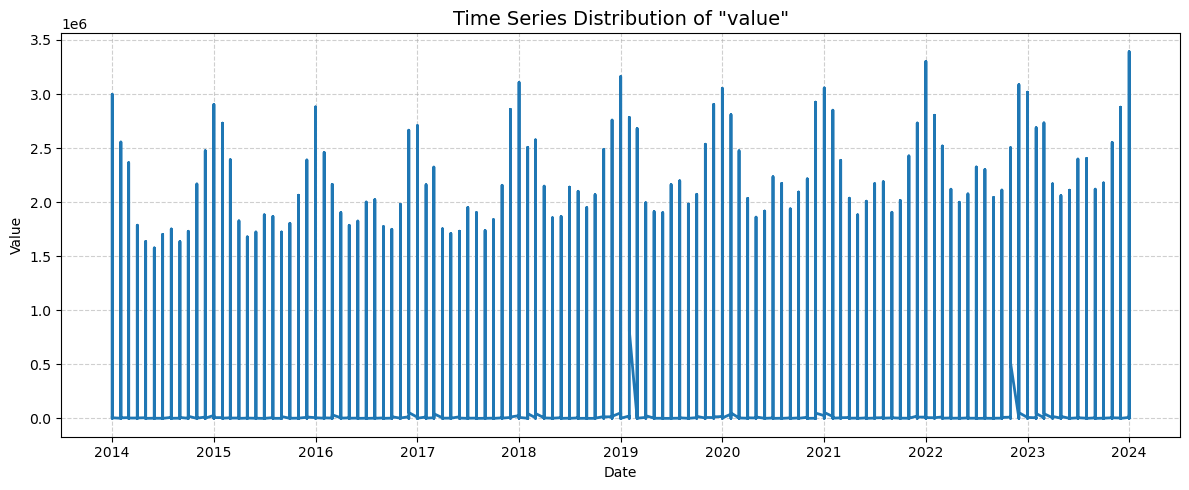

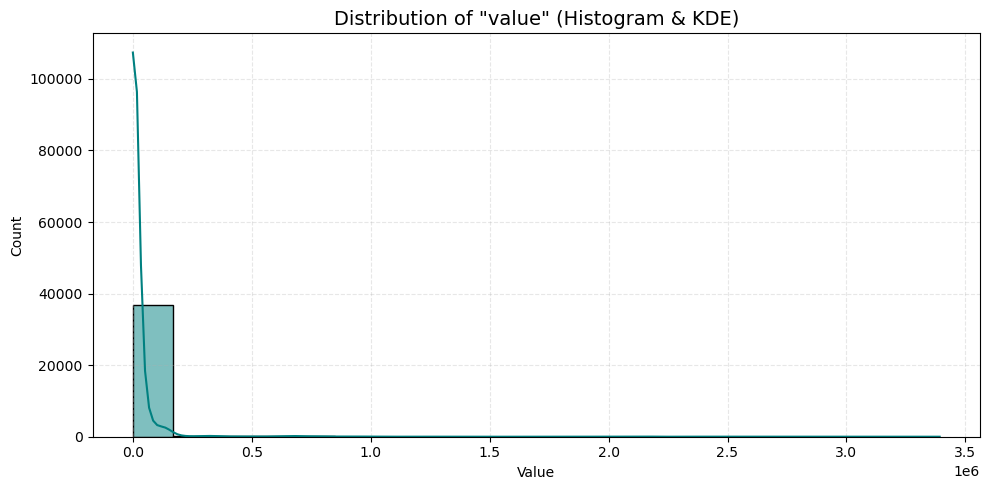

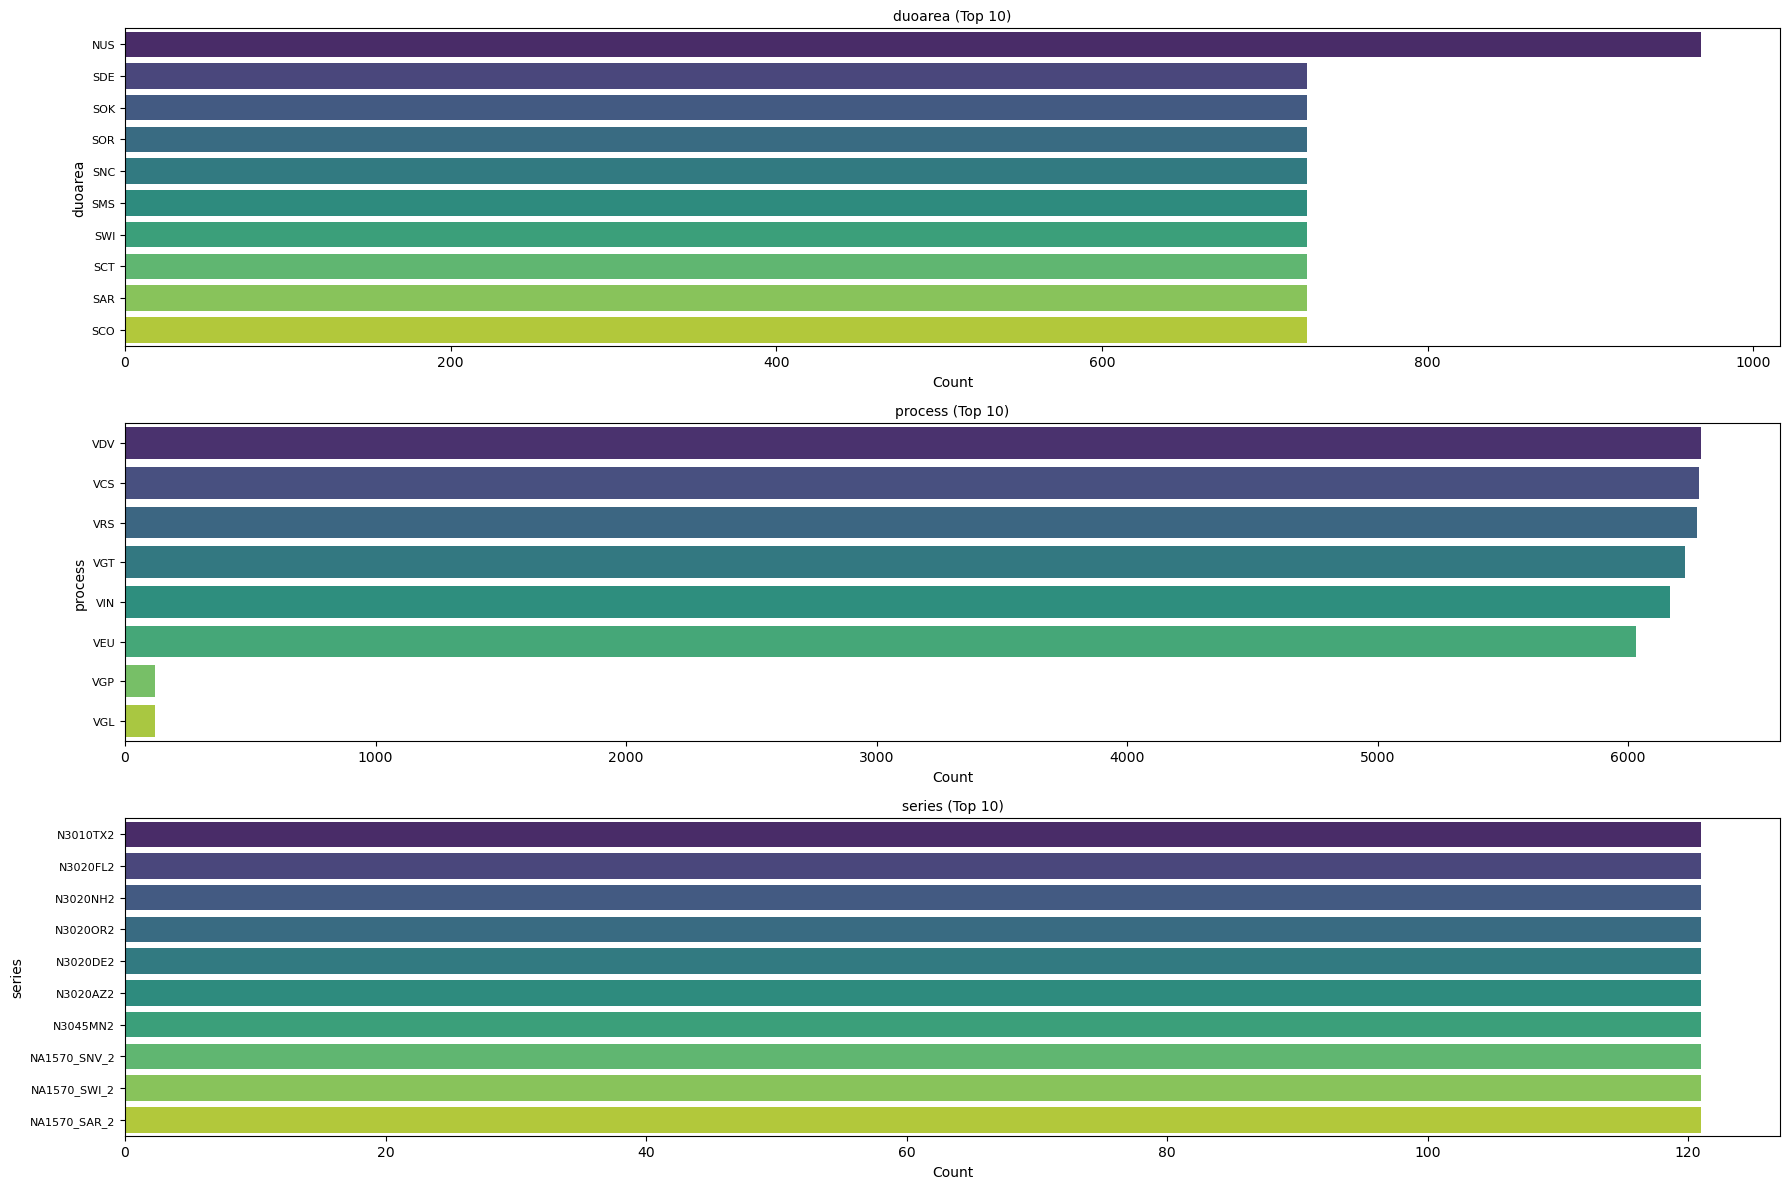

In [107]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['value'], linewidth=2, color='#1f77b4')
plt.title('Time Series Distribution of "value"', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('time_series_plot.png')

plt.figure(figsize=(10, 5))
sn.histplot(df['value'], kde=True, color='teal', bins=20)
plt.title('Distribution of "value" (Histogram & KDE)', fontsize=14)
plt.xlabel('Value')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('value_distribution.png')

fig, axes = plt.subplots(3, 1, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    if i < len(axes):
        # Check cardinality
        top_n = df[col].value_counts().nlargest(10)
        sn.barplot(x=top_n.values, y=top_n.index, ax=axes[i], palette='viridis')
        axes[i].set_title(f'{col} (Top 10)', fontsize=10)
        axes[i].set_xlabel('Count')
        axes[i].tick_params(axis='y', labelsize=8)


plt.tight_layout()
plt.savefig('categorical_distributions.png')

In [108]:
df = pd.get_dummies(df, columns=['process'], prefix='proc')

Duplicates found! Aggregating by date...


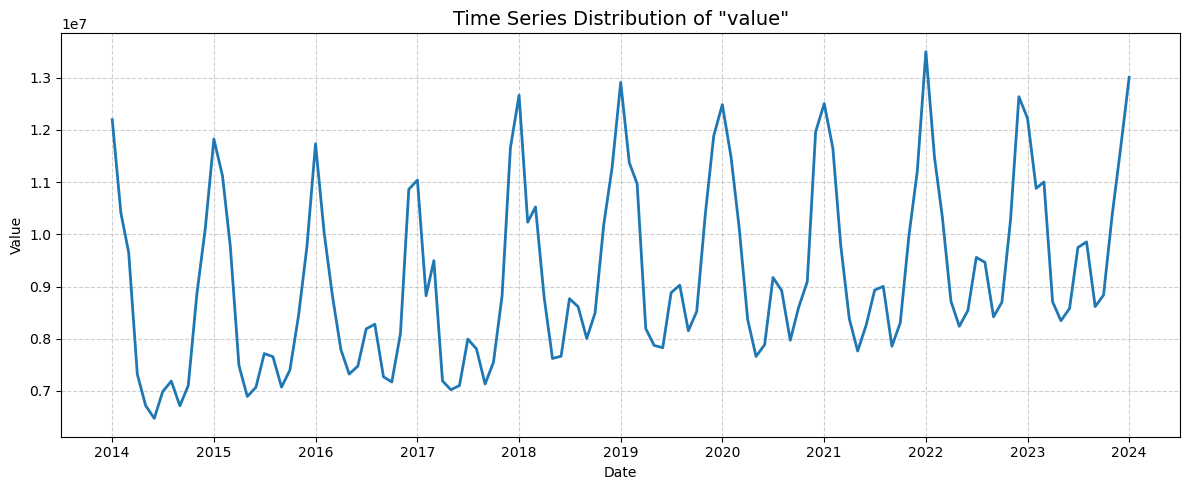

In [121]:
df = df.sort_index()

if df.index.duplicated().any():
    print("Duplicates found! Aggregating by date...")
    df_plot = df.groupby(df.index)['value'].sum() # or .sum()
else:
    df_plot = df['value']

# NOW plot the cleaned series
plt.figure(figsize=(12, 5))
plt.plot(df_plot.index, df_plot, linewidth=2, color='#1f77b4')
plt.title('Time Series Distribution of "value"', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

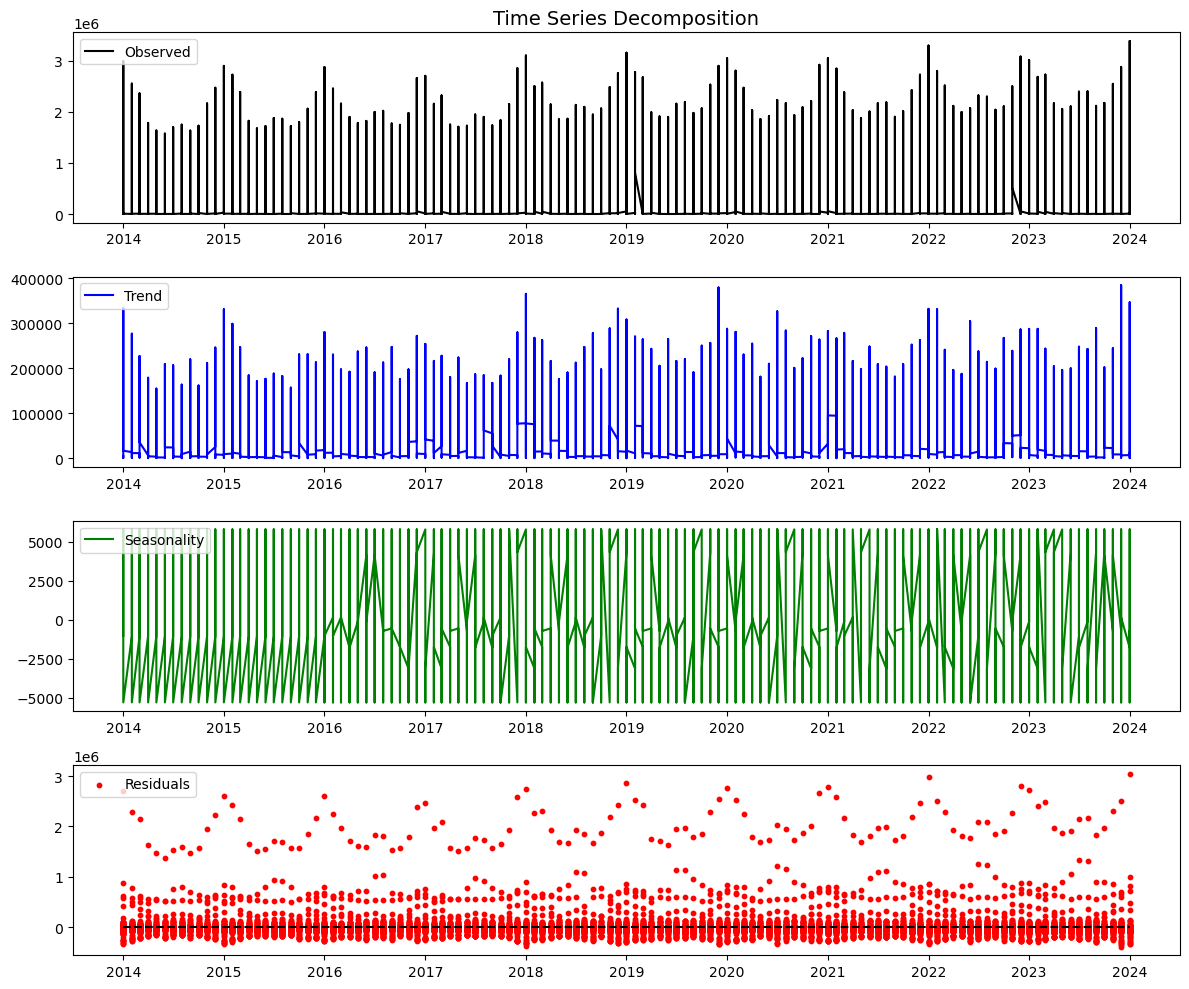

In [110]:
if df.index.freq is None:
    df.index.freq = pd.infer_freq(df.index)

# 1. Decomposition
decomposition = seasonal_decompose(df['value'], model='additive', period=12)

# 2. Plotting the 4-panel view
plt.figure(figsize=(12, 10))

# Top: Original Data
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='black')
plt.legend(loc='upper left')
plt.title('Time Series Decomposition', fontsize=14)

# Second: Trend
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend(loc='upper left')

# Third: Seasonality
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

# Bottom: Residuals (Noise)
plt.subplot(414)
plt.scatter(decomposition.resid.index, decomposition.resid, label='Residuals', color='red', s=10)
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=decomposition.resid.index.min(), xmax=decomposition.resid.index.max(), color='black', linestyle='--')

plt.tight_layout()
plt.show()

#### Stationarity Test

In [111]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    # If p-value < 0.05, data is stationary.
    # If p-value > 0.05, data is NOT stationary.
    print(dfoutput)

test_stationarity(df['value'])

Results of Dickey-Fuller Test:
Test Statistic                   -29.435615
p-value                            0.000000
#Lags Used                        42.000000
Number of Observations Used    37475.000000
dtype: float64


#### Autocorrelation Test

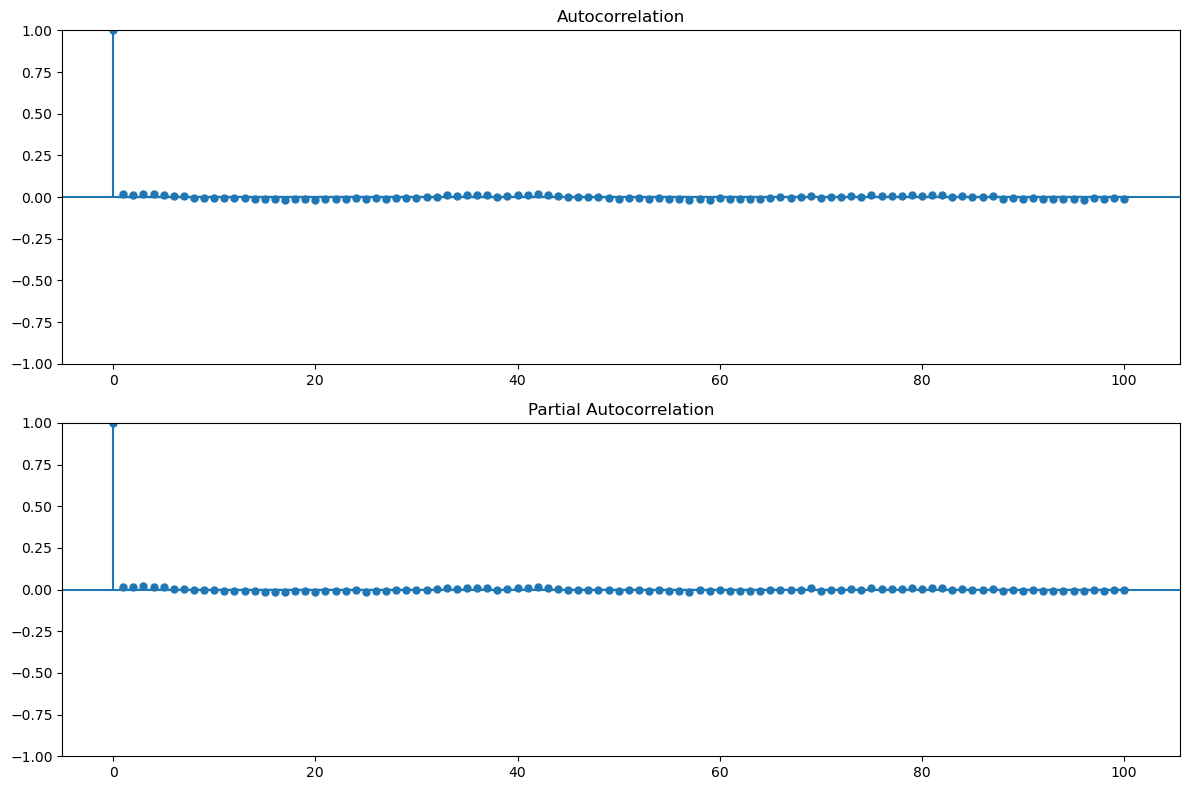

In [112]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF: Helps determine 'q' (MA term)
plot_acf(df['value'], lags=100, ax=ax1) 

# PACF: Helps determine 'p' (AR term)
plot_pacf(df['value'], lags=100, ax=ax2)

plt.tight_layout()
plt.show()

#### Forecastability Tests

##### Seasonality strength

In [122]:
df_plot = df.groupby(df.index)['value'].sum()

In [126]:
def seasonality_strength(series, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    resid = decomposition.resid.dropna()
    seasonal = decomposition.seasonal.dropna()
    var_resid = np.var(resid)
    var_seasonal = np.var(seasonal)
    return var_seasonal / (var_seasonal + var_resid)

print("Seasonality Strength:", seasonality_strength(df_plot))

Seasonality Strength: 0.9494164449948818


##### Trend Stability

In [127]:
def trend_stability(series, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    trend = decomposition.trend.dropna()
    X = np.arange(len(trend)).reshape(-1, 1)
    y = trend.values
    mask = ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    if len(y) < 2:
        return np.nan
    model = LinearRegression().fit(X, y)
    return model.score(X, y)


print("Trend Stability (R^2):", trend_stability(df_plot))

Trend Stability (R^2): 0.8579377334310707


##### Signal-to-noise ratio (SNR)

In [128]:
def signal_to_noise(series, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    trend = decomposition.trend.dropna()
    seasonal = decomposition.seasonal.dropna()
    resid = decomposition.resid.dropna()
    signal = np.var(trend) + np.var(seasonal)
    noise = np.var(resid)
    return signal / noise if noise > 0 else np.nan

print("Signal-to-Noise Ratio:", signal_to_noise(df_plot))

Signal-to-Noise Ratio: 21.406501980560986


##### Structural Complexity (Coefficient of Variation of Residuals)

In [129]:
def structural_complexity(series, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    resid = decomposition.resid.dropna()
    return variation(resid)

print("Structural Complexity (CV of Residuals):", structural_complexity(df_plot))

Structural Complexity (CV of Residuals): -54.26211074979152


##### Intrinsic Chaos (Lyapunov Exponent approximation)

In [130]:
def lyapunov_exponent(series, emb_dim=2, tau=1):
    # Simple approximation: difference between consecutive points
    diffs = np.abs(np.diff(series))
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        return 0
    return np.mean(np.log(diffs))

print("Intrinsic Chaos (Lyapunov approx):", lyapunov_exponent(df_plot.values))

Intrinsic Chaos (Lyapunov approx): 13.42140688186115


In [131]:
df.to_csv("dataset.csv")